In [ ]:
import langgraph
from langgraph.graph import StateGraph
from langgraph.graph.state import END, START, CompiledStateGraph
import json
from dotenv import load_dotenv
import os
from openai import AzureOpenAI


In [96]:
load_dotenv()
subscription_key = os.getenv("SUBSCRIPTION_KEY")
target_uri = os.getenv("TARGET_URI")

In [97]:
from pydantic import BaseModel
class ApplicationDataState(BaseModel):
    path_legal_text: str
    path_input: str
    application_data: str = ""
    legal_text: str  = ""
    legal_text_interpreter_result: str = ""
    decision: str = ""

In [98]:

api_version = "2024-12-01-preview"
endpoint = "https://ai-assetlibhub479630678989.cognitiveservices.azure.com/" 
model_name = "gpt-4o"
deployment = "gpt-4o_regensburg_lecture"

client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=subscription_key,
)

def llm_call(messages: list) -> str:
    ai_msg = client.chat.completions.create(
        messages=messages,
        model=deployment,
    )
    result = ai_msg.choices[0].message.content
    return result

In [99]:
def extractor_node(state: ApplicationDataState) -> ApplicationDataState:
    """Read Application"""
    with open(state.path_input, "r") as f:
        data = f.read()
    return {"application_data": data}


In [100]:
def crawler_node(state: ApplicationDataState) -> ApplicationDataState:
    """Read Legal Text"""
    with open(state.path_legal_text, "r") as f:
        data = f.read()
    return {"legal_text": data}

In [101]:
def legal_text_interpretor_node(state: ApplicationDataState) -> ApplicationDataState:
    print(json.dumps(state.model_dump(), indent=2))
    

    messages = [
        {
            "role": "system",
            "content": """You are a legal text interpreter. Your task is to analyze the provided legal text and application data,
                        and provide a concise summary or interpretation of the legal implications for the application.""",
        },
        {
            "role": "user",
            "content": f"""Application: {state.application_data}Legal Text: {state.legal_text}""",
        },
    ]

    response = llm_call(messages)
    return {"legal_text_interpreter_result": response}


In [102]:
def decision_maker_node(state: ApplicationDataState) -> ApplicationDataState:
    print(json.dumps(state.model_dump(), indent=2))
    
    messages = [
        {
            "role": "system",
            "content": """You are a decision maker. Your task is to analyze the provided legal text
             interpretation and make a decision based on it.""",
        },
        {
            "role": "user",
            "content": f"Legal Text Interpretation: {state.legal_text_interpreter_result}",
        },
    ]
    response = llm_call(messages)
    return {"decision": response}

In [103]:
def build() -> CompiledStateGraph:
    """Build Visa Graph."""
    builder = StateGraph(ApplicationDataState)
    # add nodes
    builder.add_node("extractor", extractor_node)
    builder.add_node("crawler", crawler_node)
    builder.add_node("legal_text_interpretor", legal_text_interpretor_node)
    builder.add_node("decision_maker", decision_maker_node)

    builder.add_edge(START, "extractor")
    builder.add_edge("extractor", "crawler")
    builder.add_edge("crawler", "legal_text_interpretor")
    builder.add_edge("legal_text_interpretor", "decision_maker")
    builder.add_edge("decision_maker", END)
    graph = builder.compile()
    return graph


In [104]:
graph = build()

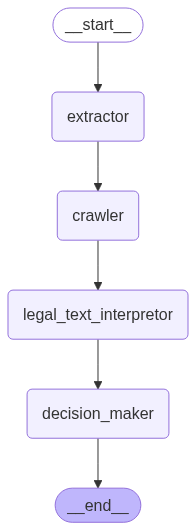

In [ ]:
# If you want, you can print the graph structure
graph

In [106]:
state = ApplicationDataState(
    path_legal_text="legal_text.txt",
    path_input="software_developer.json"
)

state_dict = state.model_dump()
response = graph.invoke(state_dict)
response

{
  "path_legal_text": "legal_text.txt",
  "path_input": "software_developer.json",
  "application_data": "{\n  \"applicant\": {\n    \"surname\": \"Doevelop\",\n    \"former_surname\": \"Smith\",\n    \"first_names\": \"John Michael\",\n    \"date_of_birth\": \"1990-01-15\",\n    \"place_of_birth\": \"New York\",\n    \"country_of_birth\": \"USA\",\n    \"current_nationality\": \"American\",\n    \"former_nationality\": \"Canadian\",\n    \"marital_status\": \"single\",\n    \"sex\": \"male\"\n  },\n  \"passport\": {\n    \"number\": \"123456789\",\n    \"issued_by\": \"USA\",\n    \"date_of_issue\": \"2020-01-01\",\n    \"valid_until\": \"2030-01-01\"\n  },\n  \"address\": {\n    \"street\": \"123 Main St\",\n    \"postal_code\": \"10001\",\n    \"city\": \"New York\",\n    \"country\": \"USA\",\n    \"email\": \"john.doe@example.com\",\n    \"phone_number\": \"+1-555-1234\"\n  },\n  \"residence\": {\n    \"permanent_residence\": \"USA\",\n    \"intended_duration_of_stay\": {\n      

{'path_legal_text': 'legal_text.txt',
 'path_input': 'software_developer.json',
 'application_data': '{\n  "applicant": {\n    "surname": "Doevelop",\n    "former_surname": "Smith",\n    "first_names": "John Michael",\n    "date_of_birth": "1990-01-15",\n    "place_of_birth": "New York",\n    "country_of_birth": "USA",\n    "current_nationality": "American",\n    "former_nationality": "Canadian",\n    "marital_status": "single",\n    "sex": "male"\n  },\n  "passport": {\n    "number": "123456789",\n    "issued_by": "USA",\n    "date_of_issue": "2020-01-01",\n    "valid_until": "2030-01-01"\n  },\n  "address": {\n    "street": "123 Main St",\n    "postal_code": "10001",\n    "city": "New York",\n    "country": "USA",\n    "email": "john.doe@example.com",\n    "phone_number": "+1-555-1234"\n  },\n  "residence": {\n    "permanent_residence": "USA",\n    "intended_duration_of_stay": {\n      "from_date": "2025-03-01",\n      "to_date": "2025-04-02"\n    },\n    "purpose_of_stay": "football

In [107]:
# You can print here what ever result you desire 
print(response["legal_text_interpreter_result"])
#AND/OR
print(response["decision"])


### Legal Implications for Application:

The provided application primarily concerns John Michael Doevelop's intent to enter Germany for a short-term stay of approximately one month, starting March 2025, for an employment-related purpose as a software engineer. The accompanying legal text outlines various provisions related to visa issuance and requirements under German immigration law.

#### Key Observations and Legal Implications:

1. **Purpose of Stay and Duration**: 
   - According to § 31(1), a visa for stays longer than 90 days typically requires prior approval from the relevant immigration authority ("Ausländerbehörde"). However, the applicant's duration of stay (March 1 to April 2, 2025) is less than 90 days, falling outside this threshold, which simplifies the application process.
   - The purpose of stay—employment—aligns with provisions for work visas (§ 19c of the Aufenthaltsgesetz).

2. **Employment Requirements**: 
   - The intended employment as a software engineer sugge